In [47]:
# Python imports
import os

# PyTorch imports
import torch
import torchvision

# Third-party imports
import matplotlib.pyplot as plt
from tabulate import tabulate

# Own imports
import utils

# 0. Constants

In [48]:
# Hyper-parameters.
LEARNING_RATE = 0.01
EPOCHS = 30
BATCH_SIZE = 100

# Others.
WIDTH, HEIGHT = 28, 28
SAVED_FILENAME = 'MNIST-FCN-0'

# 1. Dataset

I use MNIST as the dataset.

* Image width is 28.
* Image height is 28.
* Image channel is 1.
* Value of each pixel is in [0, 1].

Load training and test datasets.

In [49]:
# image, label = dataset_training[i]
# image, label = dataset_training[i]
# image is a tensor of shape (1, WIDTH, HEIGHT).
# label is a Python int number.
dataset_training = torchvision.datasets.MNIST('./data', download=True, train=True, transform=torchvision.transforms.ToTensor())
dataset_test = torchvision.datasets.MNIST('./data', download=True, train=False, transform=torchvision.transforms.ToTensor())

Create data loaders for training and test.

In [50]:
# samples = next(iter(dataloader_training))
# samples = next(iter(dataloader_test))
# samples is a Python list of len 2.
# samples[0] is a tensor of shape (BATCH_SIZE, 1, WIDTH, HEIGHT)
# samples[1] is a tensor of shape (BATCH_SIZE,)
dataloader_training = torch.utils.data.DataLoader(dataset_training, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

Inspect number of samples in both datasets.

In [51]:
headers = ['Dataset', 'Number of Samples']
rows = [
    ['Training', len(dataset_training)],
    ['Test', len(dataset_test)],
]

# Print the table.
print(tabulate(rows, headers=headers, tablefmt='github'))

| Dataset   |   Number of Samples |
|-----------|---------------------|
| Training  |               60000 |
| Test      |               10000 |


Sample images of all labels.

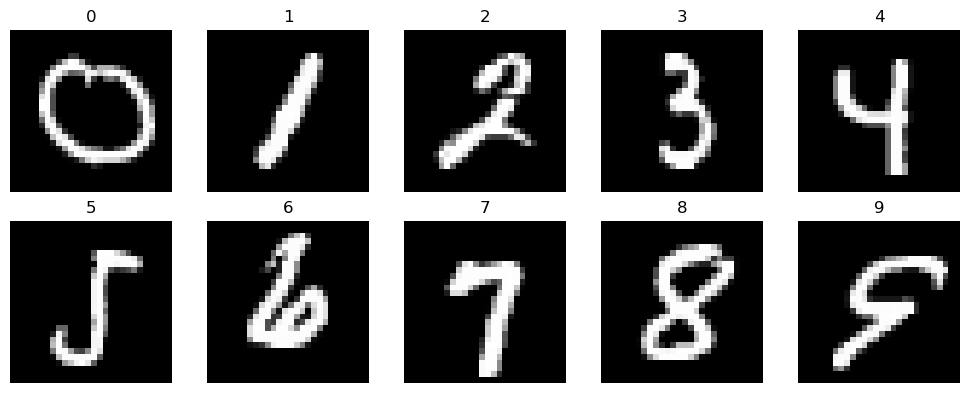

In [52]:
# Sample 10 images with labels 0 to 9.
samples = utils.sample_MNIST_with_all_labels(dataset_training)

# Plot the images.
rows, cols = 2, 5
fig, axs = plt.subplots(rows, cols, figsize=(10, 4))
for row in range(rows):
    for col in range(cols):
        axs[row, col].imshow(samples[row*cols+col].squeeze(), cmap=plt.cm.gray)
        axs[row, col].axis('off')
        axs[row, col].set_title(row*cols+col)
plt.tight_layout()

# 2. Model

In [53]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(WIDTH*HEIGHT, 10),
    torch.nn.Softmax(dim=1)
)

print('The model structure is')
print(model)

The model structure is
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
  (2): Softmax(dim=1)
)


Inspect the number of parameters.

In [54]:
num_parameters_total = 0
for params in model.parameters():
    num_parameters = 1
    size = params.size()
    for dim_size in size:
        num_parameters *= dim_size
    num_parameters_total += num_parameters

print(f'Total number of parameters: {num_parameters_total}')

Total number of parameters: 7850


Use the model to predict before training.

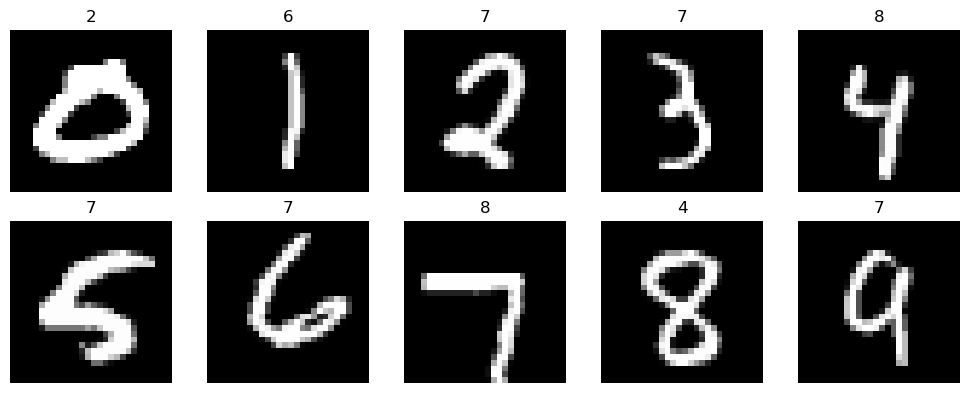

In [55]:
# Sample 10 images with labels 0 to 9 from the test dataset.
samples = utils.sample_MNIST_with_all_labels(dataset_test)

preds = {}
for label, image in samples.items():
    pred = model(image)
    preds[label] = pred.argmax(dim=1)[0].item()

# Plot the images with labels.
rows, cols = 2, 5
plt.figure(figsize=(10, 4))
for i in range(rows * cols):
    plt.subplot(rows, cols, i+1)
    plt.axis('off')
    plt.imshow(samples[i].squeeze(), cmap=plt.cm.gray)
    plt.title(preds[i])
plt.tight_layout()

# 3. Training

Define a function to load from saved data.

In [56]:
def load(model):
    
    # Retrieve saved data.
    data = torch.load(f'saved/{SAVED_FILENAME}.pt')

    # Resume model from saved data.
    state_dict = data['state_dict']
    model.load_state_dict(state_dict)

    # Return losses and accuracies for training and testing.
    return data['losses'], data['accuracies'], data['losses_test'], data['accuracies_test'], data['training_time']

Define a function to save data.

In [57]:
def save(model, losses, accuracies, losses_test, accuracies_test, training_time):
    
    # Create folder 'saved' if it does not exist.
    if not os.path.exists('saved'):
        os.makedirs('saved')

    # Construct the struct of data to save.
    data = {
        'state_dict': model.state_dict(),
        'losses': losses,
        'accuracies': accuracies,
        'losses_test': losses_test,
        'accuracies_test': accuracies_test,
        'training_time': training_time,
    }

    # Save data to the file.
    torch.save(data, f'saved/{SAVED_FILENAME}.pt')

Define a function to calculate loss and statistics on a dataset.

In [58]:
def calculateStatistics(dataloader, model, loss_fn):
    
    with torch.no_grad():
        num_batches = len(dataloader)
        num_samples = len(dataloader.dataset)
        loss, correct = 0, 0

        for images, labels in dataloader:
            # Make predictions.
            preds = model(images)

            # Calculate the loss.
            loss += loss_fn(preds, labels).item()

            # Calculate the number of correctnesses.
            correct += (preds.argmax(dim=1) == labels).type(dtype=torch.float32).sum().item()

        # Calculate the mean loss and correct.
        loss /= num_batches
        accuracy = correct / num_samples

    return loss, accuracy

Define a function to train the model for one epoch.

In [59]:
def trainOneEpoch(model, dataloader_training, dataloader_test, loss_fn, optimizer, learning_rate):

    # Constants.
    BATCHES = len(dataloader_training)
    SAMPLES = len(dataloader_training.dataset)

    # Variables.
    loss_total, correct_total = 0, 0

    for batch, [images, labels] in enumerate(dataloader_training):
        # Make predictions.
        pred = model(images)

        # Calculate the loss.
        loss = loss_fn(pred, labels)
        loss_total += loss.item()

        # Calculate the number of correctness.
        correct_total += (pred.argmax(dim=1) == labels).type(dtype=torch.float32).sum().item()

        # Back propagation.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Calculate the mean loss across all batches.
    loss = loss_total / BATCHES

    # Calculate the accuracy across all batches.
    accuracy = correct_total / SAMPLES

    # Calculate loss and correct for test.
    loss_test, accuracy_test = calculateStatistics(dataloader_test, model, loss_fn)

    return loss, accuracy, loss_test, accuracy_test

Define a function to train the model for all epochs.

In [60]:
def train(model, dataloader_training, dataloader_test, learning_rate, epochs):
    
    # Define the loss function and optimizer.
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), LEARNING_RATE)

    # Define losses and corrects for training and test.
    losses, accuracies = [], []
    losses_test, accuracies_test = [], []

    # Define a timer and start timing.
    t = utils.Timer()
    t.start()

    # Calculate losses and corrects before training.
    loss, accuracy = calculateStatistics(dataloader_training, model, loss_fn)
    losses.append(loss)
    accuracies.append(accuracy)
    loss_test, accuracy_test = calculateStatistics(dataloader_test, model, loss_fn)
    losses_test.append(loss_test)
    accuracies_test.append(accuracy_test)

    # Print statistics.
    print(f'Epoch #0: training loss ({loss:.2f}) | training accu ({accuracy:.2f}) | test loss ({loss_test:.2f}) | test accu ({accuracy_test:.2f})')

    # Run epochs.
    for epoch in range(epochs):

        loss, accuracy, loss_test, accuracy_test = trainOneEpoch(model, dataloader_training, dataloader_test, loss_fn, optimizer, learning_rate)

        # Print statistics.
        print(f'Epoch #{epoch+1}: training loss ({loss:.2f}) | training accu ({accuracy:.2f}) | test loss ({loss_test:.2f}) | test accu ({accuracy_test:.2f})')

    # Stop timing.
    t.stop()

    # Return losses, accuracies and training time.
    return losses, accuracies, losses_test, accuracies_test, t.getDuration()


Actually train the model.

In [61]:
if os.path.exists(f'saved/{SAVED_FILENAME}.pt'):
    losses, accuracies, losses_test, accuracies_test, training_time = load(model)
else:
    losses, accuracies, losses_test, accuracies_test, training_time = train(model, dataloader_training, dataloader_test, LEARNING_RATE, EPOCHS)
    save(model, losses, accuracies, losses_test, accuracies_test, training_time)

Epoch #0: training loss (2.30) | training accu (0.11) | test loss (2.30) | test accu (0.11)
Epoch #1: training loss (2.24) | training accu (0.30) | test loss (2.17) | test accu (0.46)
Epoch #2: training loss (2.08) | training accu (0.56) | test loss (2.00) | test accu (0.64)
Epoch #3: training loss (1.95) | training accu (0.68) | test loss (1.90) | test accu (0.70)
Epoch #4: training loss (1.88) | training accu (0.71) | test loss (1.85) | test accu (0.72)
Epoch #5: training loss (1.84) | training accu (0.71) | test loss (1.82) | test accu (0.72)
Epoch #6: training loss (1.82) | training accu (0.72) | test loss (1.80) | test accu (0.73)
Epoch #7: training loss (1.80) | training accu (0.73) | test loss (1.78) | test accu (0.77)
Epoch #8: training loss (1.77) | training accu (0.78) | test loss (1.75) | test accu (0.80)
Epoch #9: training loss (1.75) | training accu (0.79) | test loss (1.74) | test accu (0.81)
Epoch #10: training loss (1.74) | training accu (0.80) | test loss (1.73) | test